# Implementazione in Python

Diverse librerie sono state utilizzate per l'implementazione e la visualizzazione degli algoritmi MUSIC e ESPRIT.
La lettura e la memorizzazione di dati tabulari è gestita da *pandas*.
*numpy* permentte invece la memorizzazione di array contigui in memoria, garantendo ottime prestazioni di calcolo nonostante il livello di astrazione.
Le routines per i calcoli di algebra lineare e per la localizzazione di massimi locali sono formite dalla libreria *scipy*.
Per la visualizzazione è stata usata *matplotlib*.

Per garantire la riproducibilità delle stime, il generatore di numeri pseudo-casuali incluso in *numpy* è stato inizializzato con un seme.

In [1]:
from math import tau

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import scipy.linalg as LA
import scipy.signal as ss

from utils import *

plt.style.use('seaborn-notebook')
np.random.seed(293710966)

Come primo esempio si sceglie un segnale contenente solo le prime 6 armoniche dispari della frequenza di rete $f_0 = 50$ Hz.
Il segnale viene campionato a $f_c = 2400$ Hz consentendo la stima di armoniche fino a $1200$ Hz.
La frequenza di campionamento scelta è sufficiente poichè l'armonicha più alta ha frequenza $f_{13} = 650$ Hz.
$$
x(n) = \sum_{k=2}^7 a_{2k-1} \, cos \left(2 \pi n (2k-1)
       \frac{f_0}{f_s} + \phi_{2k-1} \right) + w(n)
$$

Il campionamento inizia al tempo $t_0 = 0$ e termina una volta raccolti $2^{12}$ campioni.
I campionamenti sono memorizzati come *IEEE 754 double-precision floating-point numbers* i quali occupano $64$ bits di memoria.
La memorizzazione del segnale richiede quindi $32$ kB di memoria.

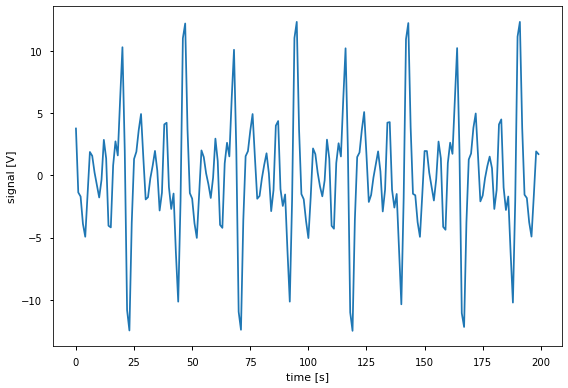

In [2]:
magnitudes = pd.read_csv('./harmonic-voltage-magnitude.csv', index_col='number')['typical']
phases = np.radians(pd.read_csv('./phases.csv', index_col='number'))['3.8']

power_freq = 50
sampling_freq = 2400
harmonic_numbers = np.arange(3, 14, 2)
no_of_harmonics = harmonic_numbers.max()

time = np.arange(4096.)

noise = np.random.normal(0, 0.1, time.size)
signal = noise.copy()

for n in harmonic_numbers:
    amp = magnitudes[n]
    phase = phases[n]
    omega = tau * n * power_freq / sampling_freq
    signal += amp * np.cos(omega * time + phase)

fig, ax = plt.subplots()
ax.plot(time[:200], signal[:200])
ax.set_xlabel('time [s]')
ax.set_ylabel('signal [V]')
fig.tight_layout()

Al fine di scegliere opportunamente la larghezza della finestra di campionamento, si calcola la lunghezza del periodo $T_0$ della frequenza di rete.
$$
T_0 = \frac{f_s}{f_0}
$$
La larghezza $M$ della finestra viene quindi calcolata pari a $10$ volte il periodo $T_0$

In [3]:
power_period = np.around(sampling_freq / power_freq).astype(int)
time_window = power_period * 10
data_size = signal.size - time_window + 1

windows = [signal[i : i + time_window] for i in range(data_size)]
data_matrix = np.vstack(windows)

Poichè la matrice di autocorrelazione stimata $\hat{R}$ è reale simmetrica, gli autovettori e autovalori vengono calcolati con un algoritmo fornito da *scipy* in grado di sfruttare questa proprietà.
$$
\hat{R} = \frac{1}{N} \mathbf{V}^t \mathbf{V}
$$

In [4]:
# signal: K largest      -> M - K : M - 1
# noise: M - K smallest  -> 0 : M - K - 1

correlation = data_matrix.conj().T @ data_matrix / data_matrix.shape[0]

signal_space_index = (time_window - no_of_harmonics, time_window - 1)
noise_space_index = (0, time_window - no_of_harmonics - 1)

signal_pca = LA.eigh(correlation, subset_by_index=signal_space_index)
noise_pca = LA.eigh(correlation, subset_by_index=noise_space_index)

signal_eigvecs = signal_pca[1].T
noise_eigvecs = noise_pca[1].T

## MUSIC
$$
P_{music}(e^{j\omega}) = \frac{1}{\sum_{i=K+1}^M |e^H s_i|^2}
$$

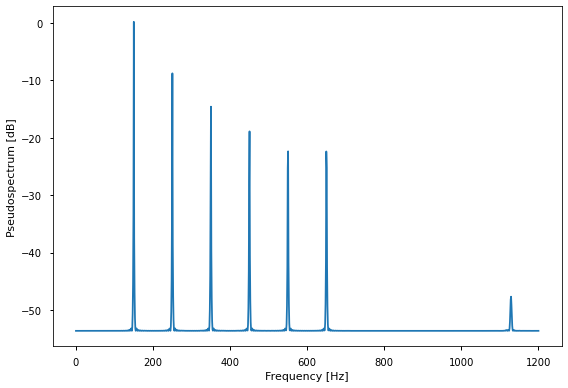

In [5]:
omegas = np.linspace(0, np.pi, sampling_freq // 2)
freqs = omegas * sampling_freq / tau

steering_matrix = np.exp(1j * np.outer(omegas, np.arange(time_window)))
pseudo_power = 1 / np.sum(np.abs(noise_eigvecs @ steering_matrix.conj().T) ** 2, axis=0)

fig, ax = plt.subplots()
plotdb(ax, freqs, pseudo_power)
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Pseudospectrum [dB]')
fig.tight_layout()

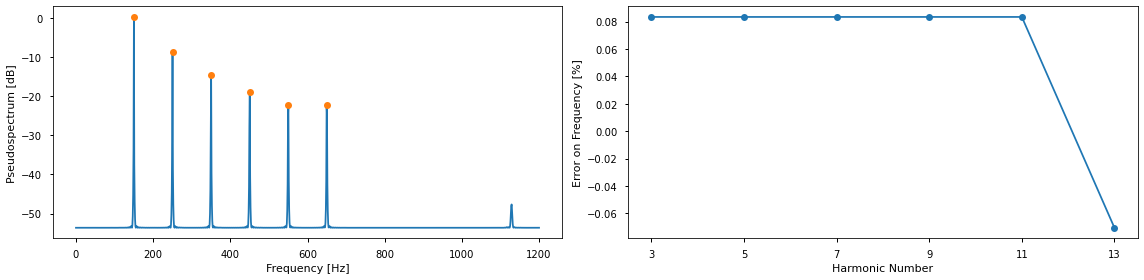

In [6]:
peaks_idx, _ = ss.find_peaks(pseudo_power)

peaks = pd.DataFrame()
peaks['omega'] = omegas[peaks_idx]
peaks['freq'] = freqs[peaks_idx]
peaks['power'] = pseudo_power[peaks_idx]
peaks = peaks.sort_values('power').tail(harmonic_numbers.size).sort_values('omega')

est_freqs = peaks.freq.values
est_omegas = peaks.omega.values
real_freqs = power_freq * harmonic_numbers
err_freqs = (est_freqs - real_freqs) / real_freqs

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

plotdb(ax1, freqs, pseudo_power)
plotdb(ax1, est_freqs, peaks.power, 'o')
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylabel('Pseudospectrum [dB]')

ax2.plot(harmonic_numbers, err_freqs * 100, 'o-')
ax2.set_ylabel('Error on Frequency [%]')
ax2.set_xlabel('Harmonic Number')
ax2.xaxis.set_major_locator(plt.FixedLocator(harmonic_numbers))

fig.tight_layout()

# Ampiezza e Fase

$$
A_{ik} = \left| \mathbf{s}_i \, \mathbf{e}_k^H \right|^2
$$

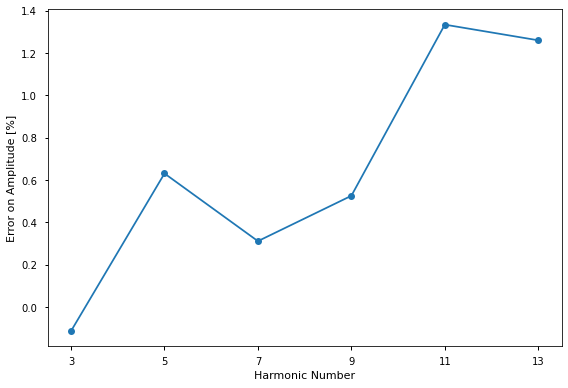

In [7]:
est_steering_matrix = np.exp(1j * np.outer(est_omegas, np.arange(time_window)))
est_noise_power = noise_pca[0].mean()

b = signal_pca[0][harmonic_numbers - 1] - est_noise_power
A = np.abs(signal_eigvecs[harmonic_numbers - 1] @ est_steering_matrix.conj().T) ** 2
est_powers = LA.solve(A, b)

est_amplitudes = np.sqrt(2 * est_powers)
real_amplitudes = magnitudes[harmonic_numbers].values
err_amplitudes = (est_amplitudes - real_amplitudes) / real_amplitudes

fig, ax = plt.subplots()

ax.plot(harmonic_numbers, err_amplitudes * 100, 'o-')
ax.set_ylabel('Error on Amplitude [%]')
ax.set_xlabel('Harmonic Number')
ax.xaxis.set_major_locator(plt.FixedLocator(harmonic_numbers))

fig.tight_layout()

In [8]:
est_freqs

array([150.12510425, 250.20850709, 350.29190992, 450.37531276,
       550.4587156 , 649.5412844 ])

In [10]:
100 * err_freqs

array([ 0.08340284,  0.08340284,  0.08340284,  0.08340284,  0.08340284,
       -0.07057163])

In [12]:
real_amplitudes

array([1.5, 4. , 4. , 0.8, 2.5, 2. ])

In [11]:
est_amplitudes

array([1.4983081 , 4.02523074, 4.01245426, 0.80420412, 2.53333612,
       2.02519053])

In [14]:
err_amplitudes * 100

array([-0.1127934 ,  0.63076841,  0.31135649,  0.52551467,  1.33344463,
        1.25952646])